# Custom sensors

In [1]:
from jax import jit
from jax import numpy as jnp
from matplotlib import pyplot as plt

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *
from jwave.geometry import circ_mask
from jwave.utils import show_field

domain = Domain((128, 128), (0.1e-3, 0.1e-3))
medium = Medium(domain=domain, sound_speed=1500.0)
time_axis = TimeAxis.from_medium(medium, cfl=0.3)

In [2]:
# Defining the initial pressure

N = domain.N
mask1 = circ_mask(N, 8, (50, 50))
mask2 = circ_mask(N, 5, (80, 60))
mask3 = circ_mask(N, 10, (64, 64))
mask4 = circ_mask(N, 30, (64, 64))
p0 = 5.0 * mask1 + 3.0 * mask2 + 4.0 * mask3 + 0.5 * mask4

p0 = 1.0 * jnp.expand_dims(p0, -1)
p0 = FourierSeries(p0, domain)

Text(0.5, 1.0, 'Initial pressure')

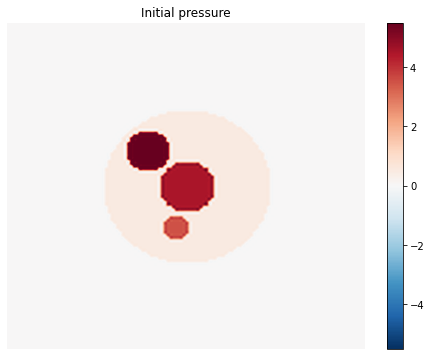

In [3]:
show_field(p0)
plt.title("Initial pressure")

In [4]:
def sensor_func(p, u, rho):
    position = (64, 24)
    # Returns the maximum velocity on a 16x16 neighborhood at
    # each timestep
    v = u.on_grid[position[0] : position[0] + 16, position[1] : position[1] + 16]
    return jnp.amax(v, axis=(0, 1))

In [5]:
@jit
def compiled_simulator(medium, p0):
    return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensor_func)

In [6]:
sensors_data = compiled_simulator(medium, p0)

In [7]:
sensors_data.shape

(599, 2)

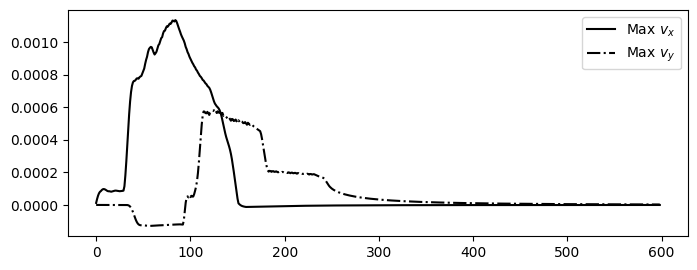

In [8]:
plt.figure(figsize=(8, 3), dpi=100)
plt.plot(sensors_data[:, 0], label="Max $v_x$", color="k")
plt.plot(sensors_data[:, 1], label="Max $v_y$", color="k", linestyle="-.")
plt.legend()